# Dataset creation
First we import the spotipy library to easily interface with the Spotify API, and <b>get the saved tracks</b>

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

client_id = "ff53c53f0f5449e29d85f52277d1e616" #insert client id
client_secret = "208a8299d75e454d82377b2514e7cad8"  #insert client secret
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                                           client_secret=client_secret,
                                                           redirect_uri="http://localhost:8888/callback",
                                                           scope="user-library-read"))

def enumerate_genre(genres):
    genre_dict = { 1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'funk', 6: 'rock', 7: 'hip hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}
    g=0
    for genre in genres:
        for key, value in genre_dict.items():
            if value in genre:
                g = key
        if g!=0:
            break
    return g

n_songs = 300       

# Preprocessing
## Feature selection
We discard the following features:
- track links, IDs and similar metadata.
- Speechiness is redundant since we already have acousticness, and we also don't care about non-musical content (i.e. podcasts or audiobooks).
- Key is not useful since I don't have perfect pitch, and don't really care about it when listening to music.
- Liveness since I don't really care if a song was recorded live or in studio (most of them are in studio anyway).
- Mode is reduntant since we have Valence, that best portrays the mood of the song (and the mode distribution is almost equiprobable).
- duration_ms is irrelevant since the vast majority of songs is in the 3-5 minutes range (and I really don't care about it)
## Discretization
pgmpy does not fully support continuous inference, so to avoid missing values and ease the inference process, kbins discretization is performed (using sklearn), transforming continuous features into discrete ones, in range [0,1]




In [2]:
#insert all preprocessing here, starting from track_features (a list of dictionaries)
def preprocessing(df):    
    #feature selection
    df.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
    # scale data with minmaxscaler
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']] = scaler.fit_transform(df[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']])
    df.to_csv('RawData.csv') #save raw data for later use

    # discretization using sklearn.preprocessing.KBinsDiscretizer
    from sklearn.preprocessing import KBinsDiscretizer
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    #fit_transform and be sure they're integers
    df['loudness']=est.fit_transform(df[['loudness']]).astype(int)
    df['valence']=est.fit_transform(df[['valence']]).astype(int)
    df['acousticness']=est.fit_transform(df[['acousticness']]).astype(int)
    df['danceability']=est.fit_transform(df[['danceability']]).astype(int)
    df['energy']=est.fit_transform(df[['energy']]).astype(int)
    df['tempo']=est.fit_transform(df[['tempo']]).astype(int)
    df['instrumentalness']= df["instrumentalness"].apply(lambda x: 1 if x>0.25 else 0)
    #return final dataframe
    return df

# <b>Data Retrieving and visualization</b>
## Retrieve liked songs

In [3]:


offset = 0
#get all saved tracks from spotify changing offset to get all tracks
numSongs=400
track_features = []
while True:
    results=sp.current_user_saved_tracks(limit=50,offset=offset)
    for item in results['items']:
        track = item['track']
        #get track supergenere from song's album
        try:
            track_genres = sp.artist(track['artists'][0]['id'])['genres']
            g=enumerate_genre(track_genres)
            if(g==0):
                continue
        except:
            continue
        track_features.append(sp.audio_features(track['id']))
        #add column genre
        track_features[-1][0]['genre'] = g
        #print in real time the number of retrieved songs, delete after each print
        print("number of retrieved songs:", len(track_features), end="\r")
        if(len(track_features)>=numSongs):
            break
    if(len(track_features)>=numSongs):
        break
    offset+=50


#only get 150 random songs
import random
random.shuffle(track_features)
track_features = track_features[:300]
#transform to dataframe and add column like and set all to 1
liked=[]
for i in range(len(track_features)):
    liked.append(pd.DataFrame(track_features[i]))
liked = pd.concat(liked)
liked['like']=1



## Retrieve songs I dislike
Since I did't want to manually select 300+ songs I dislike, I searched for playlists that contained genres I dislike, with the (simplistic) assumption that I'm going to also dislike the songs.
- the top 50 charts of US, IT and UK (150 songs)
- an EDM playlist (>200 songs)<br>
- New Country playlist (>200 songs)<br>

then I randomly sample only 300 of the total

In [ ]:
top50=[]
linkPlaylistEDM='https://open.spotify.com/playlist/2e3dcRuo9uDH6qD3NOGKAL?si=cf3587f0d60647de'
linkPlaylistTrance="https://open.spotify.com/playlist/37i9dQZF1DX91oIci4su1D?si=07682722c32f4c7e"
linkPlaylistCountry="https://open.spotify.com/playlist/37i9dQZF1DX8S0uQvJ4gaa?si=fd3ed1f432c1403f"
playlists=[linkPlaylistEDM, linkPlaylistTrance, linkPlaylistCountry]

#get top 50 songs in US, IT and great britain
markets=['US', 'IT', 'GB']
for market in markets:
    results = sp.search(q='year:2022', type='track', limit=50, offset=0, market=market)
    #get features
    for i in range(len(results['tracks']['items'])):
        #get track supergenere from artist
        try:
            track_genre = sp.artist(results['tracks']['items'][i]['artists'][0]['id'])['genres']
            g=enumerate_genre(track_genre)
            if(g==0):
                continue
        except:
            continue
        top50.append(sp.audio_features(results['tracks']['items'][i]['id']))
        print("number of retrieved songs:", len(top50), end="\r")
        #add column genre
        top50[-1][0]['genre'] = g
    print("market:", market)

checkpoint=len(top50)


market: USretrieved songs: 39
market: ITretrieved songs: 85
market: GBretrieved songs: 123


In [ ]:
for playlist in playlists:
    offset=0
    while True:
        #get tracks from link playlist
        results = sp.playlist_tracks(playlist, limit=50, offset=offset)    
        for i in range(len(results['items'])):
            #get track supergenere from artist
            try:
                track_genre = sp.artist(results['items'][i]['track']['artists'][0]['id'])['genres']
                g=enumerate_genre(track_genre)
                #check if g is NaN
                if(g==0 or g==np.nan):
                    continue
            except:
                continue
            audio_features = sp.audio_features(results['items'][i]['track']['id'])
            if(audio_features==[None]):
                continue
            top50.append(audio_features)
            print("number of retrieved songs:", len(top50)-checkpoint, end="\r")
            #add column genre
            top50[-1][0]['genre'] = g
            
        offset+=50
        if offset>=results['total']:
            break
    checkpoint=len(top50)
    print()

print("Total number of disliked songs retrieved:", len(top50))
#take only 150 random songs
random.shuffle(top50)
top50 = top50[:300]
#convert to dataframe and add column like and set all to 0
disliked=[]
for i in range(len(top50)):
    disliked.append(pd.DataFrame(top50[i]))
disliked = pd.concat(disliked)
disliked['like']=0





number of retrieved songs: 81
number of retrieved songs: 65
number of retrieved songs: 86
Total number of disliked songs retrieved: 355


In [ ]:
#concatenate liked and disliked songs
dfUnified = pd.concat([liked, disliked])
#preprocessing
dfUnified=preprocessing(dfUnified)

Save data in CSV file

In [ ]:
dfUnified.to_csv('spotifyData.csv')

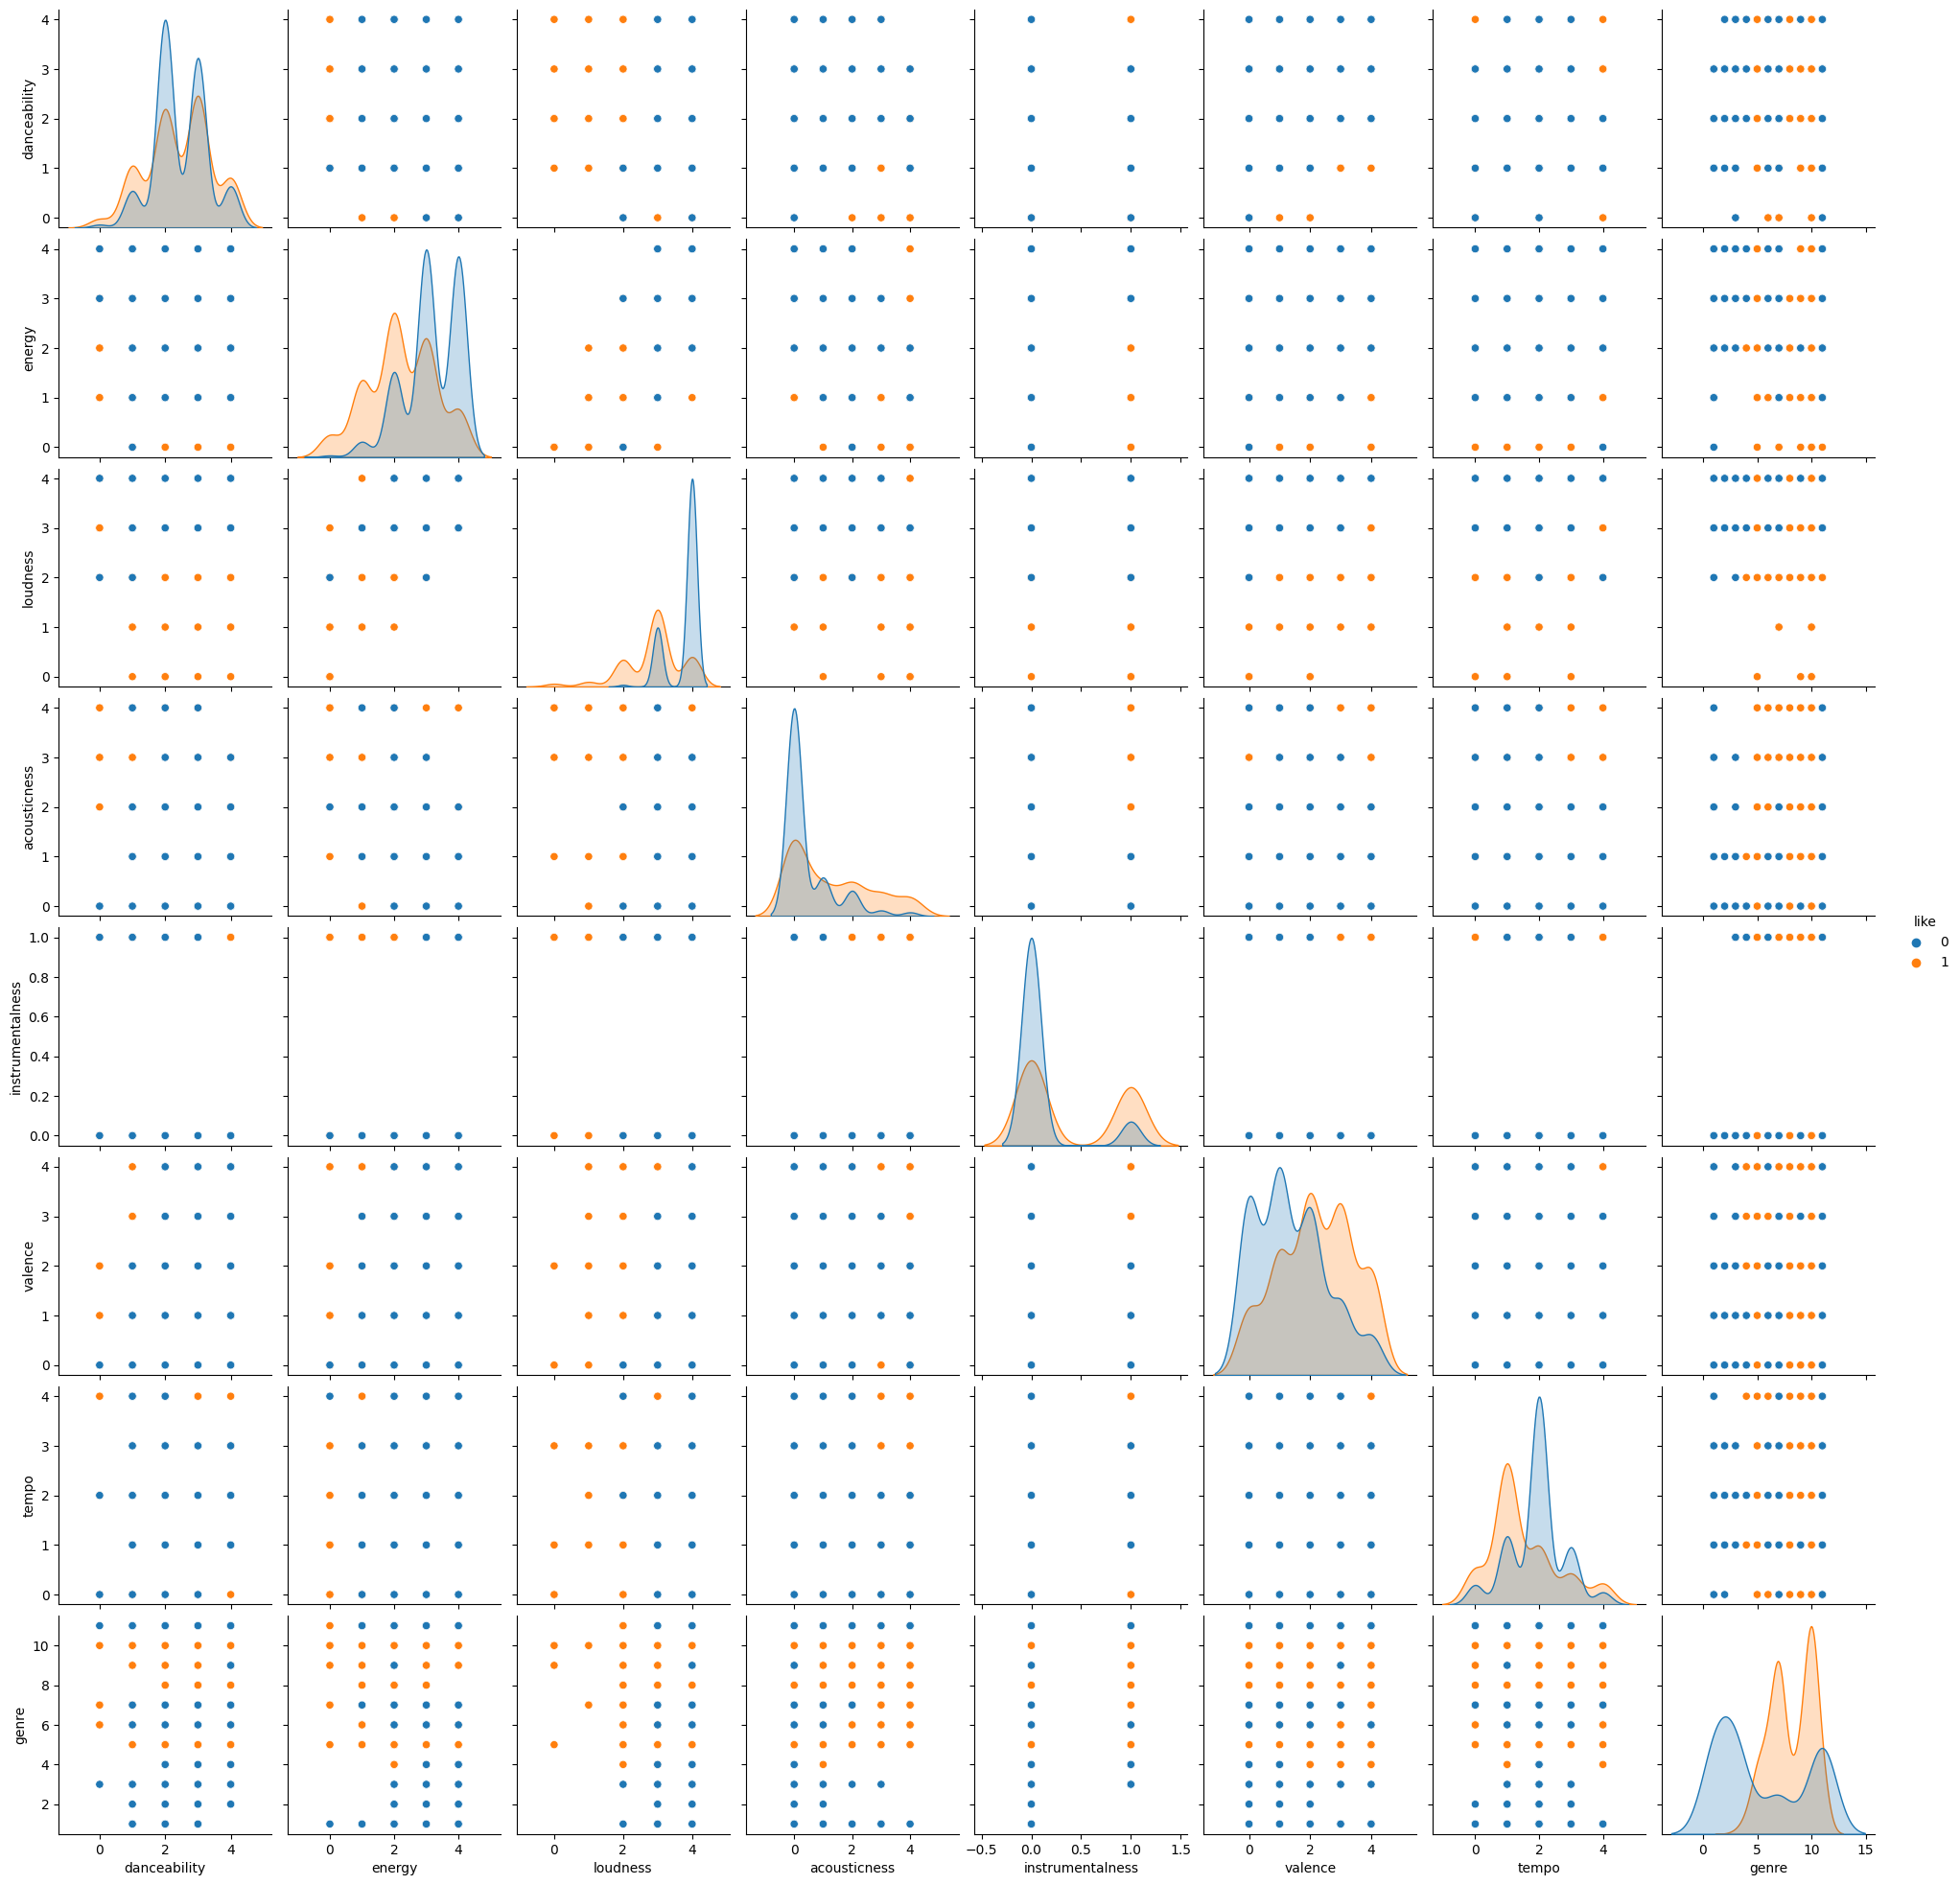

In [ ]:
#pairplot
sns.pairplot(dfUnified, hue='like')

In [ ]:
dfUnified.value_counts("like")

like
0    300
1    300
dtype: int64

# References
- Spotify API documentation: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features 
- Similar project on Kaggle (but not with Bayesian networks): 